# 神经风格迁移

In [1]:
from keras.preprocessing.image import load_img, img_to_array

target_image_path = 'img/Tubingen.jpg'
style_reference_image_path = 'img/transfer_style_reference.jpg'

width, height = load_img(target_image_path).size
print(width, height)
img_height = 400
img_width = int(width * img_height / height)
print(img_width, img_height)

Using TensorFlow backend.


720 540
533 400


In [2]:
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [4]:
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, img_height, img_width, 3))

input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('Mode loaded.')

80142336/80134624 [==============================] - 31s 0us/step
Mode loaded.


In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [6]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [7]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [8]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - 
        x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - 
        x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [9]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

content_layer = 'block5_conv2'
style_layers = ['block1_conv1',
                'block2_conv1', 
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,
                                      combination_features)

for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
    
loss += total_variation_weight * total_variation_loss(combination_image)

In [14]:
grads = K.gradients(loss, combination_image)[0]

fetch_loss_and_grads = K.function([combination_image], [loss, grads])

class Evaluator(object):
    
    def __init__(self):
        self.loss_value = None
        self.grad_values = None
    
    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value
    
    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [15]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

result_prefix = 'img/my_result'
iterations = 20

x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss,
                                     x,
                                     fprime=evaluator.grads,
                                     maxfun=20)
    print('Current loss value:', min_val)
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    imsave(fname, img)
    print('Image saved as', fname)
    end_time = time.time()
    print("Iteration %d completed in %ds" % (i, end_time - start_time))

Start of iteration 0
Current loss value: 1.63451e+09
Image saved as img/my_result_at_iteration_0.png
Iteration 0 completed in 303s
Start of iteration 1
Current loss value: 5.59672e+08
Image saved as img/my_result_at_iteration_1.png
Iteration 1 completed in 302s
Start of iteration 2
Current loss value: 3.33849e+08
Image saved as img/my_result_at_iteration_2.png
Iteration 2 completed in 301s
Start of iteration 3
Current loss value: 2.35224e+08
Image saved as img/my_result_at_iteration_3.png
Iteration 3 completed in 301s
Start of iteration 4
Current loss value: 1.82946e+08
Image saved as img/my_result_at_iteration_4.png
Iteration 4 completed in 300s
Start of iteration 5
Current loss value: 1.4138e+08
Image saved as img/my_result_at_iteration_5.png
Iteration 5 completed in 301s
Start of iteration 6
Current loss value: 1.21754e+08
Image saved as img/my_result_at_iteration_6.png
Iteration 6 completed in 301s
Start of iteration 7
Current loss value: 1.08554e+08
Image saved as img/my_result_at

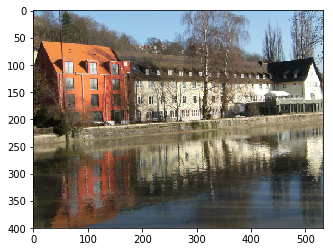

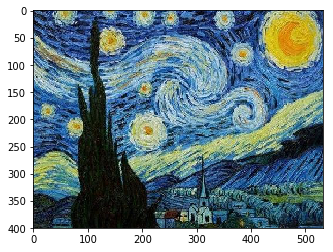

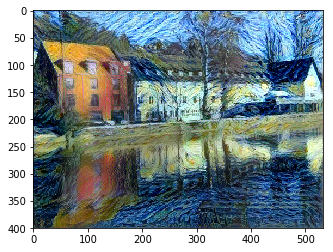

In [16]:
import matplotlib.pyplot as plt

plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

plt.imshow(img)
plt.show()